<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d3_update_t1/tutorials/W2D3_ModernRecurrentNeuralNetworks/W2D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 3, Tutorial 1
# Modern RNNs

__Content creators:__ James Evans, Bhargav Srinivasa Desikan, Anis Zahedifard

__Content reviewers:__ Lily Cheng, Melvin Selim Atay

__Production editors:__ Roberto Guidotti, Spiros Chavlis


----
# Tutorial objectives

Before we begin with exploring how RNNs excel at modelling sequences, we will explore some of the other ways we can model sequences, encode text, and make meaningful measurements using such encodings and embeddings. 

Video available at https://youtu.be/EdnZ4tS4kK0


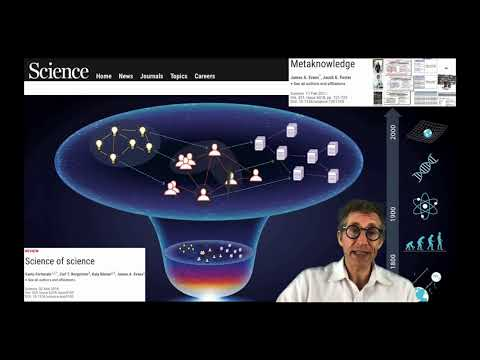

In [1]:
#@title Video 1: Introduction
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="EdnZ4tS4kK0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---
## Setup

In [2]:
# Install packages
!pip install torchtext==0.4.0
!pip install --upgrade gensim --quiet
!pip install unidecode --quiet
!pip install d2l --quiet
!pip install hmmlearn --quiet
!pip install fasttext --quiet

# Imports
import os

import time
import nltk
import torch
import random
import string
import zipfile
import fasttext
import requests

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from IPython.display import Image
from tqdm import tqdm_notebook as tqdm

from hmmlearn import hmm
from nltk import FreqDist
from nltk.corpus import brown
from d2l import torch as d2l
from gensim.models import Word2Vec
from scipy.sparse import dok_matrix
from torchtext import data, datasets
from torch.nn import functional as F
from torchtext.vocab import FastText
from nltk.tokenize import word_tokenize

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

from IPython.display import YouTubeVideo

# no critical warnings, so we supress it
import warnings
warnings.simplefilter("ignore")

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     |████████████████████████████████| 61kB 4.8MB/s 
  Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0
     |████████████████████████████████| 23.9MB 1.4MB/s 
     |████████████████████████████████| 245kB 10.4MB/s 
     |████████████████████████████████| 92kB 6.5MB/s 
     |████████████████████████████████| 378kB 13.3MB/s 
     |████████████████████████████████| 71kB 4.8MB/s 


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


In [3]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

In [4]:
# @title Helper functions
def cosine_similarity(vec_a, vec_b):
    """Compute cosine similarity between vec_a and vec_b"""
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))


def tokenize(sentences):
  #Tokenize the sentence
  #from nltk.tokenize library use word_tokenize
  token = word_tokenize(sentences)

  return token


def plot_train_val(x, train, val, train_label, val_label, title):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.title(title)
  plt.show()


#@title Load Data

def load_dataset(emb_vectors, sentence_length=50, seed=522):
  TEXT = data.Field(sequential=True,
                    tokenize=tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
  LABEL = data.LabelField(dtype=torch.float)

  train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

  TEXT.build_vocab(train_data, vectors=emb_vectors)
  LABEL.build_vocab(train_data)

  train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
  train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data,
                                                                  valid_data,
                                                                  test_data),
                                                                 batch_size=32,
                                                                 sort_key=lambda x: len(x.text),
                                                                 repeat=False,
                                                                 shuffle=True)
  vocab_size = len(TEXT.vocab)

  return TEXT, vocab_size, train_iter, valid_iter, test_iter


def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()

  response = session.get(URL, params={ 'id': id }, stream=True)
  token = get_confirm_token(response)

  if token:
    params = { 'id': id, 'confirm': token }
    response = session.get(URL, params=params, stream=True)

  save_response_content(response, destination)


def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value

  return None


def save_response_content(response, destination):
  CHUNK_SIZE = 32768

  with open(destination, "wb") as f:
    for chunk in response.iter_content(CHUNK_SIZE):
      if chunk: # filter out keep-alive new chunks
        f.write(chunk)

In [5]:
# @title Set random seed

def set_seed(seed):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


set_seed(522)

---
# Section 1: Sequences, Markov Chains & HMMs

Video available at https://youtu.be/LrNVfGiyNws


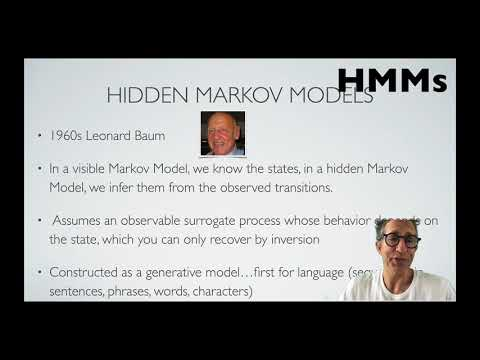

In [6]:
#@title Video 2: Sequences & Markov Processes
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="LrNVfGiyNws", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In this notebook we will be exploring the world of sequences - thinking of what kind of data can be thought of as sequences, and how these sequences can be represented as Markov Chains and Hidden Markov Models. These ideas and methods were an important part of natural language processing and language modelling, and serve as a useful way to ground ourselves before we dive into neural network methods.

## Section 1.1: What data are sequences?

Native Sequences:

- Temporally occurring events (e.g., history, stock prices)
- Temporally processed events (e.g., communication)
- Topologically connected components (e.g., polymers, peptides)

Synthetic Sequences: 

- Anything processed as a sequence (e.g., scanned pixels in an image)

Sequences can be represented as a Markov Process - since this notion of sequential data is intrinsically linked to RNNs, it is a good place for us to start, and natural language (text!) will be our sequence of choice. 

We will be using the Brown corpus which comes loaded with NLTK, and using the entire corpus - this requires a lot of RAM for some of the methods, so we recommend using a smaller subset of categories if you do not have enough RAM.

We will be using some of the code from this [tutorial](https://www.kdnuggets.com/2019/11/markov-chains-train-text-generation.html) and this [Jupyter notebook](https://github.com/StrikingLoo/ASOIAF-Markov/blob/master/ASOIAF.ipynb).

In [7]:
category = ['editorial', 'fiction', 'government', 'news', 'religion']
sentences = brown.sents(categories=category)

Now that we have our sentences, let us look at some statistics to get an idea of what we are dealing with.

In [8]:
lengths = [len(sentence) for sentence in sentences]
lengths = pd.Series(lengths)

In [9]:
lengths.quantile(.8)

30.0

In [10]:
lengths.describe()
# 14228 our of 18k

count    16617.000000
mean        20.470723
std         13.656809
min          1.000000
25%         10.000000
50%         18.000000
75%         28.000000
max        180.000000
dtype: float64

In [11]:
sentences[0:2]

[['The',
  'Fulton',
  'County',
  'Grand',
  'Jury',
  'said',
  'Friday',
  'an',
  'investigation',
  'of',
  "Atlanta's",
  'recent',
  'primary',
  'election',
  'produced',
  '``',
  'no',
  'evidence',
  "''",
  'that',
  'any',
  'irregularities',
  'took',
  'place',
  '.'],
 ['The',
  'jury',
  'further',
  'said',
  'in',
  'term-end',
  'presentments',
  'that',
  'the',
  'City',
  'Executive',
  'Committee',
  ',',
  'which',
  'had',
  'over-all',
  'charge',
  'of',
  'the',
  'election',
  ',',
  '``',
  'deserves',
  'the',
  'praise',
  'and',
  'thanks',
  'of',
  'the',
  'City',
  'of',
  'Atlanta',
  "''",
  'for',
  'the',
  'manner',
  'in',
  'which',
  'the',
  'election',
  'was',
  'conducted',
  '.']]

Since we will be modelling words as sequences in sentences, let us first collect all the words in our corpus.

In [12]:
corpus_words = []
for sentence in sentences:
  for word in sentence:
    if "''" not in word and "``" not in word:
      corpus_words.append(word)

In [13]:
print("Corpus length: "+ str(len(corpus_words)))

Corpus length: 335766


In [14]:
corpus_words[0:20]

['The',
 'Fulton',
 'County',
 'Grand',
 'Jury',
 'said',
 'Friday',
 'an',
 'investigation',
 'of',
 "Atlanta's",
 'recent',
 'primary',
 'election',
 'produced',
 'no',
 'evidence',
 'that',
 'any',
 'irregularities']

We'll now get distinct words and create a matrix to represent all these words - this is necessary because we will be using this matrix to look at the probability of the words in sequences.

In [15]:
distinct_words = list(set(corpus_words))
word_idx_dict = {word: i for i, word in enumerate(distinct_words)}
distinct_words_count = len(list(set(corpus_words)))

In [16]:
print("Number of distinct words: " + str(distinct_words_count))

Number of distinct words: 27485


In [17]:
next_word_matrix = np.zeros([distinct_words_count, distinct_words_count])

In [18]:
word_idx_dict

{'gig': 0,
 'mitigate': 1,
 'discounts': 2,
 'pars': 3,
 '175': 4,
 'versus': 5,
 'tightening': 6,
 'determine': 7,
 'grand-slam': 8,
 'starts': 9,
 'premium': 10,
 '3-10': 11,
 'demonstrations': 12,
 'surprisingly': 13,
 'throat': 14,
 'Sons': 15,
 'circumstance': 16,
 'rupee': 17,
 'Forum': 18,
 'Sherman': 19,
 'involves': 20,
 'rulers': 21,
 'model': 22,
 'Hopkins': 23,
 'declared': 24,
 '800': 25,
 'anti-Catholic': 26,
 'residence': 27,
 '412-413': 28,
 'marred': 29,
 'honoree': 30,
 'axis': 31,
 'pretends': 32,
 'barrage': 33,
 'Poverty': 34,
 'Philippine': 35,
 'cliffhanging': 36,
 'gladness': 37,
 '2-over-par': 38,
 'windup': 39,
 'low': 40,
 'expire': 41,
 'disarm': 42,
 'divided': 43,
 'million': 44,
 'radiate': 45,
 'Jonathan': 46,
 'patched': 47,
 'submitted': 48,
 'worker': 49,
 'substitutionary': 50,
 'assisted': 51,
 'questioned': 52,
 'inane': 53,
 'They': 54,
 'candlewick': 55,
 'democracy': 56,
 'stapling': 57,
 'hasten': 58,
 'acts': 59,
 'goods': 60,
 'Abe': 61,
 'gr

In the following lines of code we are populating the matrix that tracks the next word in a sentence.

In [19]:
for i, word in enumerate(corpus_words[:-1]):
  first_word_idx = word_idx_dict[word]
  next_word_idx = word_idx_dict[corpus_words[i+1]]
  next_word_matrix[first_word_idx][next_word_idx] +=1

## Section 1.2: What is a Markov Chain or Model?

A Markov Chain (or Model) is a:
- stochastic model describing a sequence of possible events
- the probability of each event depends only on the state attained in the previous event.
- a countably infinite sequence, in which the chain moves state at discrete time steps, gives a discrete-time Markov chain (DTMC) [vs. a continuous-time process or CTMC].
- The classic formal language model is a Markov Model

*Helpful explanations from [eric mjl's tutorial](https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/#non-autoregressive-homoskedastic-emissions)*!



The simplest Markov models assume that we have a _system_ that contains a finite set of states,
and that the _system_ transitions between these states with some probability at each time step $t$,
thus generating a sequence of states over time.
Let's call these states $S$, where

$$S = \{s_1, s_2, ..., s_n\}$$

To keep things simple, let's start with three states:

$$S = \{s_1, s_2, s_3\}$$

A Markov model generates a sequence of states, with one possible realization being:

$$\{s_1, s_1, s_1, s_3, s_3, s_3, s_2, s_2, s_3, s_3, s_3, s_3, s_1, ...\}$$

And generically, we represent it as a sequence of states $x_t, x_{t+1}... x_{t+n}$. (We have chosen a different symbol to not confuse the "generic" state with the specific realization. Graphically, a plain and simple Markov model looks like the following:




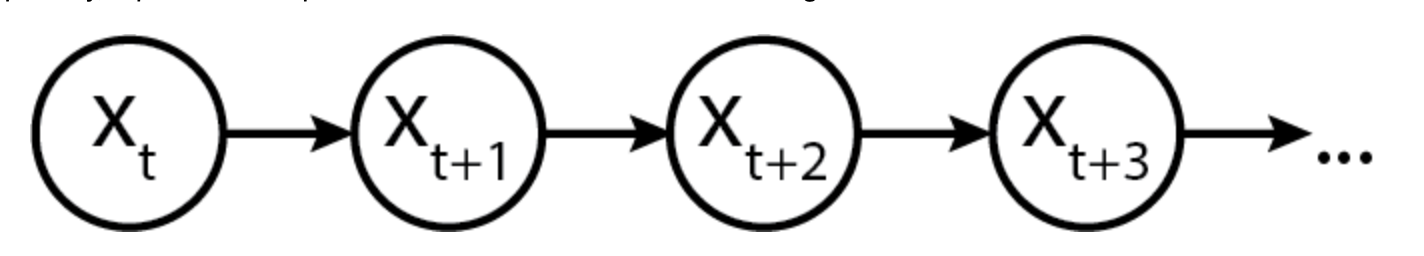

### Modelling transitions between states

To know how a system transitions between states, we now need a **transition matrix**.
The transition matrix describes the probability of transitioning from one state to another.
(The probability of staying in the same state is semantically equivalent to transitioning to the same state.) 

By convention, transition matrix rows correspond to the state at time $t$,
while columns correspond to state at time $t+1$.
Hence, row probabilities sum to one,
because the probability of transitioning to the next state depends on only the current state,
and all possible states are known and enumerated.

Let's call the transition matrix $P_{transition}$.
The symbol etymology, which usually gets swept under the rug in mathematically-oriented papers, are as follows: 

- $transition$ doesn't refer to time but simply indicates that it is for transitioning states, 
- $P$ is used because it is a probability matrix.

$$ P_{transition} = 
\begin{pmatrix}
    p_{11} & p_{12} & p_{13}\\
    p_{21} & p_{22} & p_{23}\\
    p_{31} & p_{32} & p_{33}\\
\end{pmatrix}
$$

Using the transition matrix, we can express that the system likes to stay in the state that it enters into,
by assigning larger probability mass to the diagonals.
Alternatively, we can express that the system likes to transition out of states that it enters into,
by assigning larger probability mass to the off-diagonal.

In our case, this matrix is created by seeing which words appear after each other.

In [20]:
def most_likely_word_after(aWord):
  most_likely = next_word_matrix[word_idx_dict[aWord]].argmax()
  return distinct_words[most_likely]

Using our most likely word function, we can begin to create chains of words and create sequences. In the code below we create a naive chain that simply choses the most likely word.

In [21]:
def naive_chain(word, length=15):
  current_word = word
  sentence = word

  for _ in range(length):
    sentence += ' '
    next_word = most_likely_word_after(current_word)
    sentence += next_word
    current_word = next_word
  return sentence

In [22]:
print(naive_chain('the'))
print(naive_chain('I'))
print(naive_chain('What'))
print(naive_chain('Park'))

the United States , and the United States , and the United States , and the
I have been a new members of the United States , and the United States ,
What is a new members of the United States , and the United States , and
Park , and the United States , and the United States , and the United States


We can now be a little more sophisticated, and return words in a sequence using a weighted choice.

In [23]:
def weighted_choice(objects, weights):
  """
  Returns randomly an element from the sequence of 'objects',
      the likelihood of the objects is weighted according
      to the sequence of 'weights', i.e. percentages.
  """

  weights = np.array(weights, dtype=np.float64)
  sum_of_weights = weights.sum()
  # standardization:
  np.multiply(weights, 1 / sum_of_weights, weights)
  weights = weights.cumsum()
  x = random.random()
  for i in range(len(weights)):
    if x < weights[i]:
      return objects[i]

In [24]:
def sample_next_word_after(word, alpha=0):
  next_word_vector = next_word_matrix[word_idx_dict[word]] + alpha
  likelihoods = next_word_vector/next_word_vector.sum()
  return weighted_choice(distinct_words, likelihoods)

In [25]:
sample_next_word_after('the')

'Kowalski'

In [26]:
def stochastic_chain(word, length=15):
  current_word = word
  sentence = word

  for _ in range(length):
    sentence += ' '
    next_word = sample_next_word_after(current_word)
    sentence += next_word
    current_word = next_word

  return sentence

In [27]:
stochastic_chain('Hospital')

'Hospital , subversives . Today , a special safety citation and nonmetallic mines are vigorous but'

Neat - we can create stochastic chains for a single word. For a more effective language model, we would want to model sets of words - in the following cells, we create sets of words to predict a chain after a sequence.

In [28]:
k = 3
sets_of_k_words = [' '.join(corpus_words[i:i+k]) for i, _ in enumerate(corpus_words[:-k])]
print([len(list(set(sets_of_k_words))), len(sets_of_k_words)])

[285383, 335763]


In [29]:
sets_count = len(list(set(sets_of_k_words)))
next_after_k_words_matrix = dok_matrix((sets_count, len(distinct_words)))
print(next_after_k_words_matrix.shape)

(285383, 27485)


In [30]:
distinct_sets_of_k_words = list(set(sets_of_k_words))
k_words_idx_dict = {word: i for i, word in enumerate(distinct_sets_of_k_words)}
distinct_k_words_count = len(list(set(sets_of_k_words)))
print(len(sets_of_k_words))

335763


In [31]:
for i, word in enumerate(sets_of_k_words[:-k]):
  if i % 50000 == 0:
    print(i)
  word_sequence_idx = k_words_idx_dict[word]
  next_word_idx = word_idx_dict[corpus_words[i+k]]
  next_after_k_words_matrix[word_sequence_idx, next_word_idx] += 1

0
50000
100000
150000
200000
250000
300000


In [32]:
def stochastic_chain(words, chain_length=15, words_length=2):
  current_words = words.split(' ')
  if len(current_words) != words_length:
    raise ValueError(f'wrong number of words, expected {words_length}')
  sentence = words

  for _ in range(chain_length):
    sentence += ' '
    next_word = sample_next_word_after_sequence(' '.join(current_words))
    sentence += next_word
    current_words = current_words[1:]+[next_word]
  return sentence

In [33]:
def sample_next_word_after_sequence(word_sequence, alpha = 0):
  next_word_vector = next_after_k_words_matrix[k_words_idx_dict[word_sequence]] + alpha
  likelihoods = next_word_vector/next_word_vector.sum()
  return weighted_choice(distinct_words, likelihoods.toarray())

In [34]:
k_words_idx_dict

{'world peace ,': 0,
 'memorized . 10': 1,
 'Ross Barnett .': 2,
 'of the reality': 3,
 'cash box into': 4,
 'The Taoists were': 5,
 'a half times': 6,
 'crusade for Christian': 7,
 'area , with': 8,
 'look which always': 9,
 'speak to them': 10,
 'further reading during': 11,
 'membership preparation in': 12,
 'irreconcilable . Through': 13,
 'the achievement of': 14,
 'than theirs ,': 15,
 '-- all pulling': 16,
 'very well all': 17,
 'making inroads in': 18,
 'of the transport': 19,
 'two textile machinery': 20,
 'the teakettle .': 21,
 'that smiles today': 22,
 "Day Adventists' world": 23,
 'Although it looked': 24,
 '. Watch people': 25,
 'of uniform size': 26,
 'thrill to the': 27,
 'sue for recovery': 28,
 ', self-contained ,': 29,
 "football's hall of": 30,
 'a friend :': 31,
 'given to improvement': 32,
 'grey eyes ,': 33,
 'for Mitchell .': 34,
 'A crowd of': 35,
 'even in death': 36,
 'with Mr. Willcox': 37,
 'I as their': 38,
 'point since 1934': 39,
 'for membership churche

In [35]:
stochastic_chain('Judges under the', words_length=3)

'Judges under the jurisdiction of the United States throughout the world . By analogy , the church also'

In [36]:
distinct_sets_of_k_words[:10]

['world peace ,',
 'memorized . 10',
 'Ross Barnett .',
 'of the reality',
 'cash box into',
 'The Taoists were',
 'a half times',
 'crusade for Christian',
 'area , with',
 'look which always']



## Section 1.3: What is a Hidden Markov Model?

A 1960s advance (by Leonard Baum and colleagues): Hidden Markov Models are:
- a Markov model in which the system modeled is assumed to be a Markov process/chain with unobservable ("hidden") states. 
- HMM assumes there is another surrogate process whose behavior "depends" on the state--you learn about the state by observing the surrogate process. 
- HMMs have successfully been applied in fields where the goal is to recover a data sequence not immediately observable (but other data that depend on the sequence are).
- The first dominant application: Speech and text processing (1970s)

In this sub-section we will use the python library [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states), which is part of the *scikit-learn* ecosystem. [nlg-with-hmmlearn](https://github.com/mfilej/nlg-with-hmmlearn) offers useful code snippets to adapt ```hmmlearn``` for text data. Because we are using a package that offers many out of the box implementations for HMMs, we don't have to worry about the states, transition matrices, 

In [37]:
sentences = brown.sents(categories=category)
words = [word.lower() for sentence in sentences for word in sentence]
lengths = [len(sentence) for sentence in sentences]
alphabet = set(words)

In [38]:
le = LabelEncoder()
_ = le.fit(list(alphabet))

In [39]:
seq = le.transform(words)
features = np.fromiter(seq, np.int64)
features = np.atleast_2d(features).T
fd = FreqDist(seq)

Now that we have our data setup, we can create our model. We use a multinomial HMM with 8 states, and can either do a random initialisation or use word frequences. We recommend trying both options!

In [40]:
def get_model(num_states):
  print("Initial parameter estimation using built-in method")
  model = hmm.MultinomialHMM(n_components=num_states, init_params='ste')
  return model

In [41]:
# we haven't run this code, but it returns a model that is initialised with information of relative frequencies of words
def frequencies(num_states):
  print("Initial parameter estimation using relative frequencies")

  frequencies = np.fromiter((fd.freq(i) for i in range(len(alphabet))),
                            dtype=np.float64)
  emission_prob = np.stack([frequencies]*num_states)

  model = hmm.MultinomialHMM(n_components=num_states, init_params='st')
  model.emissionprob_ = emission_prob
  return model


print(frequencies(2))

Initial parameter estimation using relative frequencies
MultinomialHMM(algorithm='viterbi', init_params='st', n_components=2, n_iter=10,
               params='ste', random_state=None, startprob_prior=1.0, tol=0.01,
               transmat_prior=1.0, verbose=False)


In [42]:
## This is lenghty (~17 mins)
num_states = 8
model = get_model(num_states)
# the line below is commented out, but is an alternate way to initialise a model
# model = frequencies(num_states)
model = model.fit(features, lengths)

Initial parameter estimation using built-in method


In [43]:
num_lines = 5
for _i in range(num_lines):
  random_len = 15
  set_seed(_i)
  symbols, _states = model.sample(random_len)

  output = le.inverse_transform(np.squeeze(symbols))
  for word in output:
    print(word, end=" ")
  print()

some miniature of to had incurred uniforms ; the the the sky painter was had 
rd. do . december its organization this program lest and who realtors to , this 
, her coosa of by many john than healthy , , . of : dequindre 
simply kenny to blood-bought inquirer is christ more negro had receipts ? state-owned at up 
lyon some at '' half all with of he was was the . again given 


### Useful links for Markov Models and HMM:

[Markov Chain Text](https://towardsdatascience.com/simulating-text-with-markov-chains-in-python-1a27e6d13fc6)

[Python QuantEcon: Finite Markov Chains with Finance](https://python.quantecon.org/finite_markov.html)

[Markov Models from the ground up, with python](https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/)

[GenTex](https://github.com/nareshkumar66675/GenTex)

[HMM learn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html)

## Think! 1: Transition probabilities 

***WAXER NOTE: Don't know where to put it***

We have seen how we can use sequences of text to form probability chains, as well as how we can use out of the box models to generate text. In this exercise, you will be using your own data to generate sequences using ```hmmlearn``` or any other implementation of a markov model. Explore the transition probabilities in your corpus and generate sentences. For example, one such exploration can be - how does using a model with the word frequencies incorporated in compare to using a default model?

Perform any one such comparison or exploration, and generate 3 sentences or 50 words using your model.

---
# Section 2: Word Embeddings


Video available at https://youtu.be/P_I2Ram6Tac


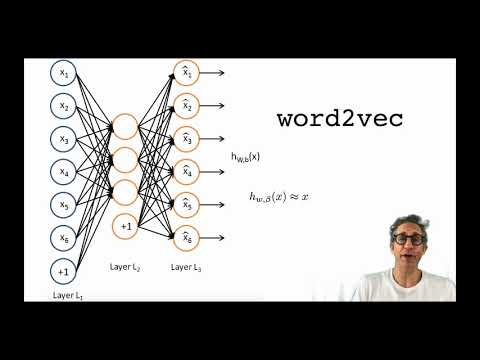

In [44]:
#@title Video 3: Textual Dimension Reduction
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="P_I2Ram6Tac", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Words or subword units such as morphemes are the basic units that we use to express meaning  in language. The technique of mapping words to vectors of real numbers is known as word embedding. 

Last week, we saw that one-hot word vectors cannot accurately express the similarity between different words. The cosine similarity between the one-hot vectors of any two different words is zero.

This week, we will be using pretrained fastText embeddings, a context-oblivious embedding similar to word2vec. 

In [45]:
#@title Download FastText English Embeddings of dimension 100

# 1d2fzekxTgDIA9LEYskPXT1sfccgAGmUF
# file_id = '11qRoFOUiGnvM04ERcN_6Qn6O_dJ2KPLk'
# destination = 'cc.en.100.bin.zip'
# download_file_from_google_drive(file_id, destination)
!wget -O cc.en.100.bin.gz https://osf.io/2frqg/download

os.listdir('.')
with zipfile.ZipFile('cc.en.100.bin.gz', 'r') as zip_ref:
  zip_ref.extractall('.')

--2021-06-23 14:15:35--  https://osf.io/2frqg/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca633fbc4980091403080?action=download&direct&version=1 [following]
--2021-06-23 14:15:37--  https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca633fbc4980091403080?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1512369270 (1.4G) [application/octet-stream]
Saving to: ‘cc.en.100.bin.gz’

cc.en.100.bin.gz    100%[===================>]   1.41G  37.4MB/s    in 39s     

2021-06-23 14:16:17 (37.2 MB/s) - ‘cc.en.100.bin.gz’ saved [1512369270/1512369270]



In [46]:
#####Load 100 dimension FastText Vectors using FastText library
ft_en_vectors = fasttext.load_model('cc.en.100.bin')

In [47]:
print("Length of the embedding is: ", len(ft_en_vectors.get_word_vector('king')))
print("Embedding for the word King is: ", ft_en_vectors.get_word_vector('king'))

Length of the embedding is:  100
Embedding for the word King is:  [-0.04045481 -0.10617249 -0.27222311  0.06879666  0.16408321  0.00276707
  0.27080125 -0.05805573 -0.31865698  0.03748008 -0.00254088  0.13805169
 -0.00182498 -0.08973497  0.00319015 -0.19619396 -0.09858181 -0.10103802
 -0.08279888  0.0082208   0.13119364 -0.15956607  0.17203182  0.0315701
 -0.25064597  0.06182072  0.03929246  0.05157393  0.03543638  0.13660161
  0.05473648  0.06072914 -0.04709269  0.17394426 -0.02101276 -0.11402624
 -0.24489872 -0.08576579 -0.00322696 -0.04509873 -0.00614253 -0.05772085
 -0.073414   -0.06718913 -0.06057961  0.10963406  0.1245006  -0.04819863
  0.11408057  0.11081408  0.06752145 -0.01689911 -0.01186301 -0.11716368
 -0.01287614  0.10639337 -0.04243141  0.01057278 -0.0230855  -0.04930984
  0.04717607  0.03696446  0.0015999  -0.02193867 -0.01331578  0.11102925
  0.1686794   0.05814958 -0.00296521 -0.04252011 -0.00352389  0.06267346
 -0.07747819 -0.08959802 -0.02445797 -0.08913022  0.1342223

Cosine similarity is used for similarities between words. Similarity is a scalar between 0 and 1.

Now find the 10 most similar words to "King"

In [48]:
ft_en_vectors.get_nearest_neighbors("king", 10)  # Most similar by key

[(0.8168574571609497, 'prince'),
 (0.796097457408905, 'emperor'),
 (0.7907207608222961, 'kings'),
 (0.7655220627784729, 'lord'),
 (0.7435404062271118, 'king-'),
 (0.7394551634788513, 'chieftain'),
 (0.7307553291320801, 'tyrant'),
 (0.7226710319519043, 'conqueror'),
 (0.719561755657196, 'kingly'),
 (0.718187689781189, 'queen')]

### Word Similarity

Video available at https://youtu.be/djxZMSm7h2k


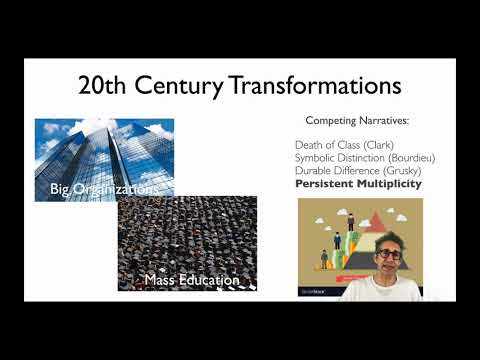

In [49]:
#@title Video 4: Semantic Measurements
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="djxZMSm7h2k", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

More on similarity between words. Let's check how similar different pairs of word are. Feel free to play around.



In [50]:
def getSimilarity(word1, word2):
  v1 = ft_en_vectors.get_word_vector(word1)
  v2 = ft_en_vectors.get_word_vector(word2)
  return cosine_similarity(v1, v2)

print("Similarity between the words King and Queen: ", getSimilarity("king", "queen"))
print("Similarity between the words King and Knight: ", getSimilarity("king", "knight"))
print("Similarity between the words King and Rock: ", getSimilarity("king", "rock"))
print("Similarity between the words King and Twenty: ", getSimilarity("king", "twenty"))

## Try the same for two more pairs
# print("Similarity between the words ___ and ___: ", getSimilarity(...))
# print("Similarity between the words ___ and ___: ", getSimilarity(...))

# print("Similarity between the words ___ and ___: ", getSimilarity(...))
# print("Similarity between the words ___ and ___: ", getSimilarity(...))

Similarity between the words King and Queen:  0.71818775
Similarity between the words King and Knight:  0.6881009
Similarity between the words King and Rock:  0.28928387
Similarity between the words King and Twenty:  0.19655468


### Homonym Words

Find the similarity for homonyms with their different meanings. The first one has been implemented for you.

In [51]:
#######################     Words with multiple meanings     ##########################
print("Similarity between the words Cricket and Insect: ", getSimilarity("cricket", "insect"))
print("Similarity between the words Cricket and Sport: ", getSimilarity("cricket", "sport"))

## Try the same for two more pairs
# print("Similarity between the words ___ and ___: ", getSimilarity(...))
# print("Similarity between the words ___ and ___: ", getSimilarity(...))

# print("Similarity between the words ___ and ___: ", getSimilarity(...))
# print("Similarity between the words ___ and ___: ", getSimilarity(...))

Similarity between the words Cricket and Insect:  0.40722153
Similarity between the words Cricket and Sport:  0.58123744


### Word Analogies

Embeddings can be used to find word analogies.
Let's try it:
1.   Man : Woman  ::  King : _____
2.  Germany: Berlin :: France : ______
3.  Leaf : Tree  ::  Petal : _____





In [52]:
## Use get_analogies() funnction. The words have to be in the order Positive, negative,  Positve

# Man : Woman  ::  King : _____
# Positive=(woman, king), Negative=(man)
print(ft_en_vectors.get_analogies("woman", "man", "king",1))

# Germany: Berlin :: France : ______
# Positive=(berlin, frannce), Negative=(germany)
print(ft_en_vectors.get_analogies("berlin", "germany", "france",1))

# Leaf : Tree  ::  Petal : _____
# Positive=(tree, petal), Negative=(leaf)
print(ft_en_vectors.get_analogies("tree", "leaf", "petal",1))

# Hammer : Nail  ::  Comb : _____
# Positive=(nail, comb), Negative=(hammer)
print(ft_en_vectors.get_analogies("nail", "hammer", "comb",1))

[(0.8162637948989868, 'queen')]
[(0.8568049669265747, 'paris')]
[(0.7037209272384644, 'flower')]
[(0.6908746361732483, 'hair')]


But, does it always work?


1.   Poverty : Wealth  :: Sickness : _____
2.   train : board :: horse : _____

In [53]:
# Poverty : Wealth  :: Sickness : _____
print(ft_en_vectors.get_analogies("wealth", "poverty", "sickness",1))

# train : board :: horse : _____
print(ft_en_vectors.get_analogies("board", "train", "horse",1))

[(0.615874171257019, 'affliction')]
[(0.5437814593315125, 'bull')]


###Section 2.1: Multilingual Embeddings

Traditionally, word embeddings have been lnaguage-specific, with embeddings for each language trained separately and existing in entirely different vector spaces. But, what if we wanted to compare words in one language to another language? Say, we want to create a text classifier with a corpus consisting of English and Spanish words. 

We use the multilingual word embeddings provided in fastText. More information can be found [here](https://engineering.fb.com/2018/01/24/ml-applications/under-the-hood-multilingual-embeddings/).

#### Training multilingual embeddings
We first train separate embeddings for each language using fastText and a combination of data from Facebook and Wikipedia. Then, we find a dictionary of common words between the two languages. The dictionaries are automatically induced from parallel data - datasets that consist of a pair of sentences in two different languages that have the same meaning. 

Then, we find a matrix that projects the embeddings into a common space between the given languages. The matrix is designed to minimize the distance between a word $x_i$ and its projection $y_i$. If our dictionary consists of pairs $(x_i, y_i)$, our projector $M$ would be: 

$$M = \text{argmin}_W\sum_i ||x_i - Wy_ii||^2$$

Also, the projector matrix $W$ is constrained to e orthogonal so that original distances between word embedding vectors are preserved. Multilingual models are trained by using our multilingual word embeddings as the base representations in DeepText and “freezing” them, or leaving them unchanged during the training process. 


After going through this, try to replicate the above exercises but in different languages! 


In [54]:
#@title Download FastText French Embeddings of dimension 100

!wget -O cc.fr.100.bin.gz https://osf.io/6tqvp/download

with zipfile.ZipFile('cc.fr.100.bin.gz', 'r') as zip_ref:
    zip_ref.extractall('.')

--2021-06-23 14:16:58--  https://osf.io/6tqvp/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca6421a175b009644f2c1?action=download&direct&version=1 [following]
--2021-06-23 14:16:59--  https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca6421a175b009644f2c1?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1509233727 (1.4G) [application/octet-stream]
Saving to: ‘cc.fr.100.bin.gz’

cc.fr.100.bin.gz    100%[===================>]   1.41G  36.8MB/s    in 39s     

2021-06-23 14:17:38 (37.1 MB/s) - ‘cc.fr.100.bin.gz’ saved [1509233727/1509233727]



In [55]:
#####Load 100 dimension FastText Vectors using FastText library
french = fasttext.load_model('cc.fr.100.bin')

First, we take a look at the cosine similarity between different languages without projecting them into the same vector space. As you can see, the same words seem to be close to $0$ cosine similarity in different languages - so neither similar nor dissimilar. 

In [56]:
hello = ft_en_vectors.get_word_vector('hello')
hi = ft_en_vectors.get_word_vector('hi')
bonjour = french.get_word_vector('bonjour')

print("Cosine Similarity between HI and HELLO: {}".format(cosine_similarity(hello, hi)))
print("Cosine Similarity between BONJOUR and HELLO: {}".format(cosine_similarity(hello, bonjour)))

Cosine Similarity between HI and HELLO: 0.7028388977050781
Cosine Similarity between BONJOUR and HELLO: 0.20523205399513245


In [57]:
cat = ft_en_vectors.get_word_vector('cat')
chatte = french.get_word_vector('chatte')
chat = french.get_word_vector('chat')

print("Cosine Similarity between cat and chatte: {}".format(cosine_similarity(cat, chatte)))
print("Cosine Similarity between cat and chat: {}".format(cosine_similarity(cat, chat)))
print("Cosine Similarity between chatte and chat: {}".format(cosine_similarity(chatte, chat)))

Cosine Similarity between cat and chatte: -0.013087842613458633
Cosine Similarity between cat and chat: -0.02490561455488205
Cosine Similarity between chatte and chat: 0.6003134250640869


First, let's define a list of words that are in common between English and French. We'll be using this to make our training matrices. 

In [58]:
en_words = set(ft_en_vectors.words)
fr_words = set(french.words)
overlap = list(en_words & fr_words)
bilingual_dictionary = [(entry, entry) for entry in overlap]

We define a few functions to make our lives a bit easier: `make_training_matrices` takes in the source words, target language words, and the set of common words. It then creates a matrix of all the word embeddings of all common words between the languages (in each language). These are our training matrices. 

The function `learn_transformation` then takes in these matrices, normalizes them, and then performs SVD, which aligns the source language to the target and returns a transformation matrix. 

In [59]:
def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
  source_matrix = []
  target_matrix = []

  for (source, target) in tqdm(bilingual_dictionary):
    source_matrix.append(source_dictionary.get_word_vector(source))
    target_matrix.append(target_dictionary.get_word_vector(target))

  return np.array(source_matrix), np.array(target_matrix)


# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)


def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
  """
  Source and target matrices are numpy arrays, shape
  (dictionary_length, embedding_dimension). These contain paired
  word vectors from the bilingual dictionary.
  """
  # optionally normalize the training vectors
  if normalize_vectors:
      source_matrix = normalized(source_matrix)
      target_matrix = normalized(target_matrix)

  # perform the SVD
  product = np.matmul(source_matrix.transpose(), target_matrix)
  U, s, V = np.linalg.svd(product)

  # return orthogonal transformation which aligns source language to the target
  return np.matmul(U, V)

Now, we just have to put it all together! 

In [60]:
source_training_matrix, target_training_matrix = make_training_matrices(ft_en_vectors, french, bilingual_dictionary)

In [61]:
transform = learn_transformation(source_training_matrix, target_training_matrix)

Let's run the same examples as above, but this time, whenever we use French words, matrix multiply the embedding by the transpose of the transform matrix. That works a lot better! 

In [62]:
hello = ft_en_vectors.get_word_vector('hello')
hi = ft_en_vectors.get_word_vector('hi')
bonjour = np.matmul(french.get_word_vector('bonjour'), transform.T)

print("Cosine Similarity between HI and HELLO: {}".format(cosine_similarity(hello, hi)))
print("Cosine Similarity between BONJOUR and HELLO: {}".format(cosine_similarity(hello, bonjour)))

Cosine Similarity between HI and HELLO: 0.7028388977050781
Cosine Similarity between BONJOUR and HELLO: 0.5818607807159424


In [63]:
cat = ft_en_vectors.get_word_vector('cat')
chatte = np.matmul(french.get_word_vector('chatte'), transform.T)
chat = np.matmul(french.get_word_vector('chat'), transform.T)

print("Cosine Similarity between cat and chatte: {}".format(cosine_similarity(cat, chatte)))
print("Cosine Similarity between cat and chat: {}".format(cosine_similarity(cat, chat)))
print("Cosine Similarity between chatte and chat: {}".format(cosine_similarity(chatte, chat)))

Cosine Similarity between cat and chatte: 0.4327274560928345
Cosine Similarity between cat and chat: 0.6866634488105774
Cosine Similarity between chatte and chat: 0.6003133654594421


In [64]:
# @markdown Clean Up of Previous Files (MUST RUN THIS CELL)
!rm cc.en.100.bin.zip
!rm cc.fr.100.bin.gz
!rm cc.en.100.bin
!rm cc.fr.100.bin

rm: cannot remove 'cc.en.100.bin.zip': No such file or directory


## Section 2.2: Creating Word Embeddings

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).  In order to achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence is a list of words.
Calling `Word2Vec(sentences, iter=1)` will run two passes over the sentences iterator (or, in general iter+1 passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
`Word2vec` accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

`model = Word2Vec(sentences, min_count=10)  # default value is 5`


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

`model = Word2Vec(sentences, size=200)  # default value is 100`


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

`model = Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization`

In [65]:
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

In [66]:
def create_word2vec_model(category='news', size=50, sg=1, min_count=5):
  try:
    sentences = brown.sents(categories=category)
    model = Word2Vec(sentences, vector_size=size, sg=sg, min_count=min_count)

  except (AttributeError, TypeError):
      raise AssertionError('Input variable "category" should be a string or list,'
      '"size", "sg", "min_count" should be integers')

  return model

def model_dictionary(model):
  words = list(w2vmodel.wv.key_to_index)
  return words

def get_embedding(word, model):
  if word in w2vmodel.wv.key_to_index:
    return model.wv[word]
  else:
    return None

In [67]:
all_categories = brown.categories()

In [68]:
all_categories

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [69]:
w2vmodel = create_word2vec_model(all_categories)

In [70]:
print(model_dictionary(w2vmodel))

['the', ',', '.', 'of', 'and', 'to', 'a', 'in', 'that', 'is', 'was', 'for', '``', "''", 'The', 'with', 'it', 'as', 'he', 'his', 'on', 'be', ';', 'I', 'by', 'had', 'at', '?', 'not', 'are', 'from', 'or', 'this', 'have', 'an', 'which', '--', 'were', 'but', 'He', 'her', 'one', 'they', 'you', 'all', 'would', 'him', 'their', 'been', ')', '(', 'has', 'will', 'who', 'more', 'out', 'It', 'we', 'she', 'said', 'there', 'up', 'In', ':', 'than', 'them', 'into', 'no', 'its', 'about', 'so', 'when', 'can', 'only', 'other', '!', 'could', 'time', 'if', 'what', 'some', 'But', 'A', 'two', 'any', 'may', 'do', 'first', 'like', 'these', 'over', 'such', 'This', 'me', 'my', 'man', 'our', 'made', 'new', 'most', 'now', 'then', 'must', 'also', 'Af', 'did', 'even', 'back', 'before', 'years', 'through', 'And', 'many', 'She', 'much', 'way', 'down', 'your', 'should', 'There', 'where', 'They', 'Mr.', 'after', 'because', 'people', 'too', 'little', 'those', 'very', 'own', 'make', 'good', 'each', 'well', 'work', 'just', 

In [71]:
print(get_embedding('weather', w2vmodel))

[-0.06151473  0.23835483 -0.23015307 -0.06441894 -0.1448257  -0.35914284
  0.32680228  0.0705587  -0.24019703 -0.10843001 -0.0859292  -0.13540994
  0.28457886  0.03531958 -0.291357    0.05644765 -0.2680171   0.25465655
 -0.35093993 -0.4837291   0.1764466   0.40316436  0.54427284 -0.13325305
 -0.03368726  0.07708641  0.15426771  0.25252235 -0.29950383  0.07863628
 -0.29660144 -0.29442164  0.16690718 -0.1513691  -0.01564987 -0.23389833
  0.3251053   0.1723209   0.03559833 -0.04401367  0.06809956  0.1331483
 -0.18795799  0.1814605   0.41720417  0.39947623  0.12258974 -0.25030518
  0.29709217  0.03277702]


## Section 2.3: Visualizing Word Embedding

We can now obtain the word embeddings for any word in the dictionary using word2vec. Let's visualize these embeddings to get an inuition of what these embeddings mean. The word embeddings obtained from word2vec model are in high dimensional space. We will use `PCA` to pick the 2 features that capture the most variance in the embeddings in order to represent them in a 2D space.


For each word in `keys`, we pick the top 10 similar words (using cosine similarity) and plot them.  

 What should be the arrangement of similar words?
 What should be arrangement of the key clusters with respect to each other?
 

In [72]:
keys = ['voters', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

In [73]:
def get_cluster_embeddings(keys):
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
    embeddings = []
    words = []
    if not word in w2vmodel.wv.key_to_index:
      print('The word ', word, 'is not in the dictionary')
      continue

    for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
      words.append(similar_word)
      embeddings.append(w2vmodel.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

  return embeddings_en_2d, word_clusters

In [74]:
def tsne_plot_similar_words(title, labels, embedding_clusters,
                            word_clusters, a, filename=None):
  plt.figure(figsize=(16, 9))
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))
  for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, color=color, alpha=a, label=label)
    for i, word in enumerate(words):
      plt.annotate(word,
                   alpha=0.5,
                   xy=(x[i], y[i]),
                   xytext=(5, 2),
                   textcoords='offset points',
                   ha='right',
                   va='bottom',
                   size=10)
  plt.legend(loc="lower left")
  plt.title(title)
  plt.grid(True)
  if filename:
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
  plt.show()

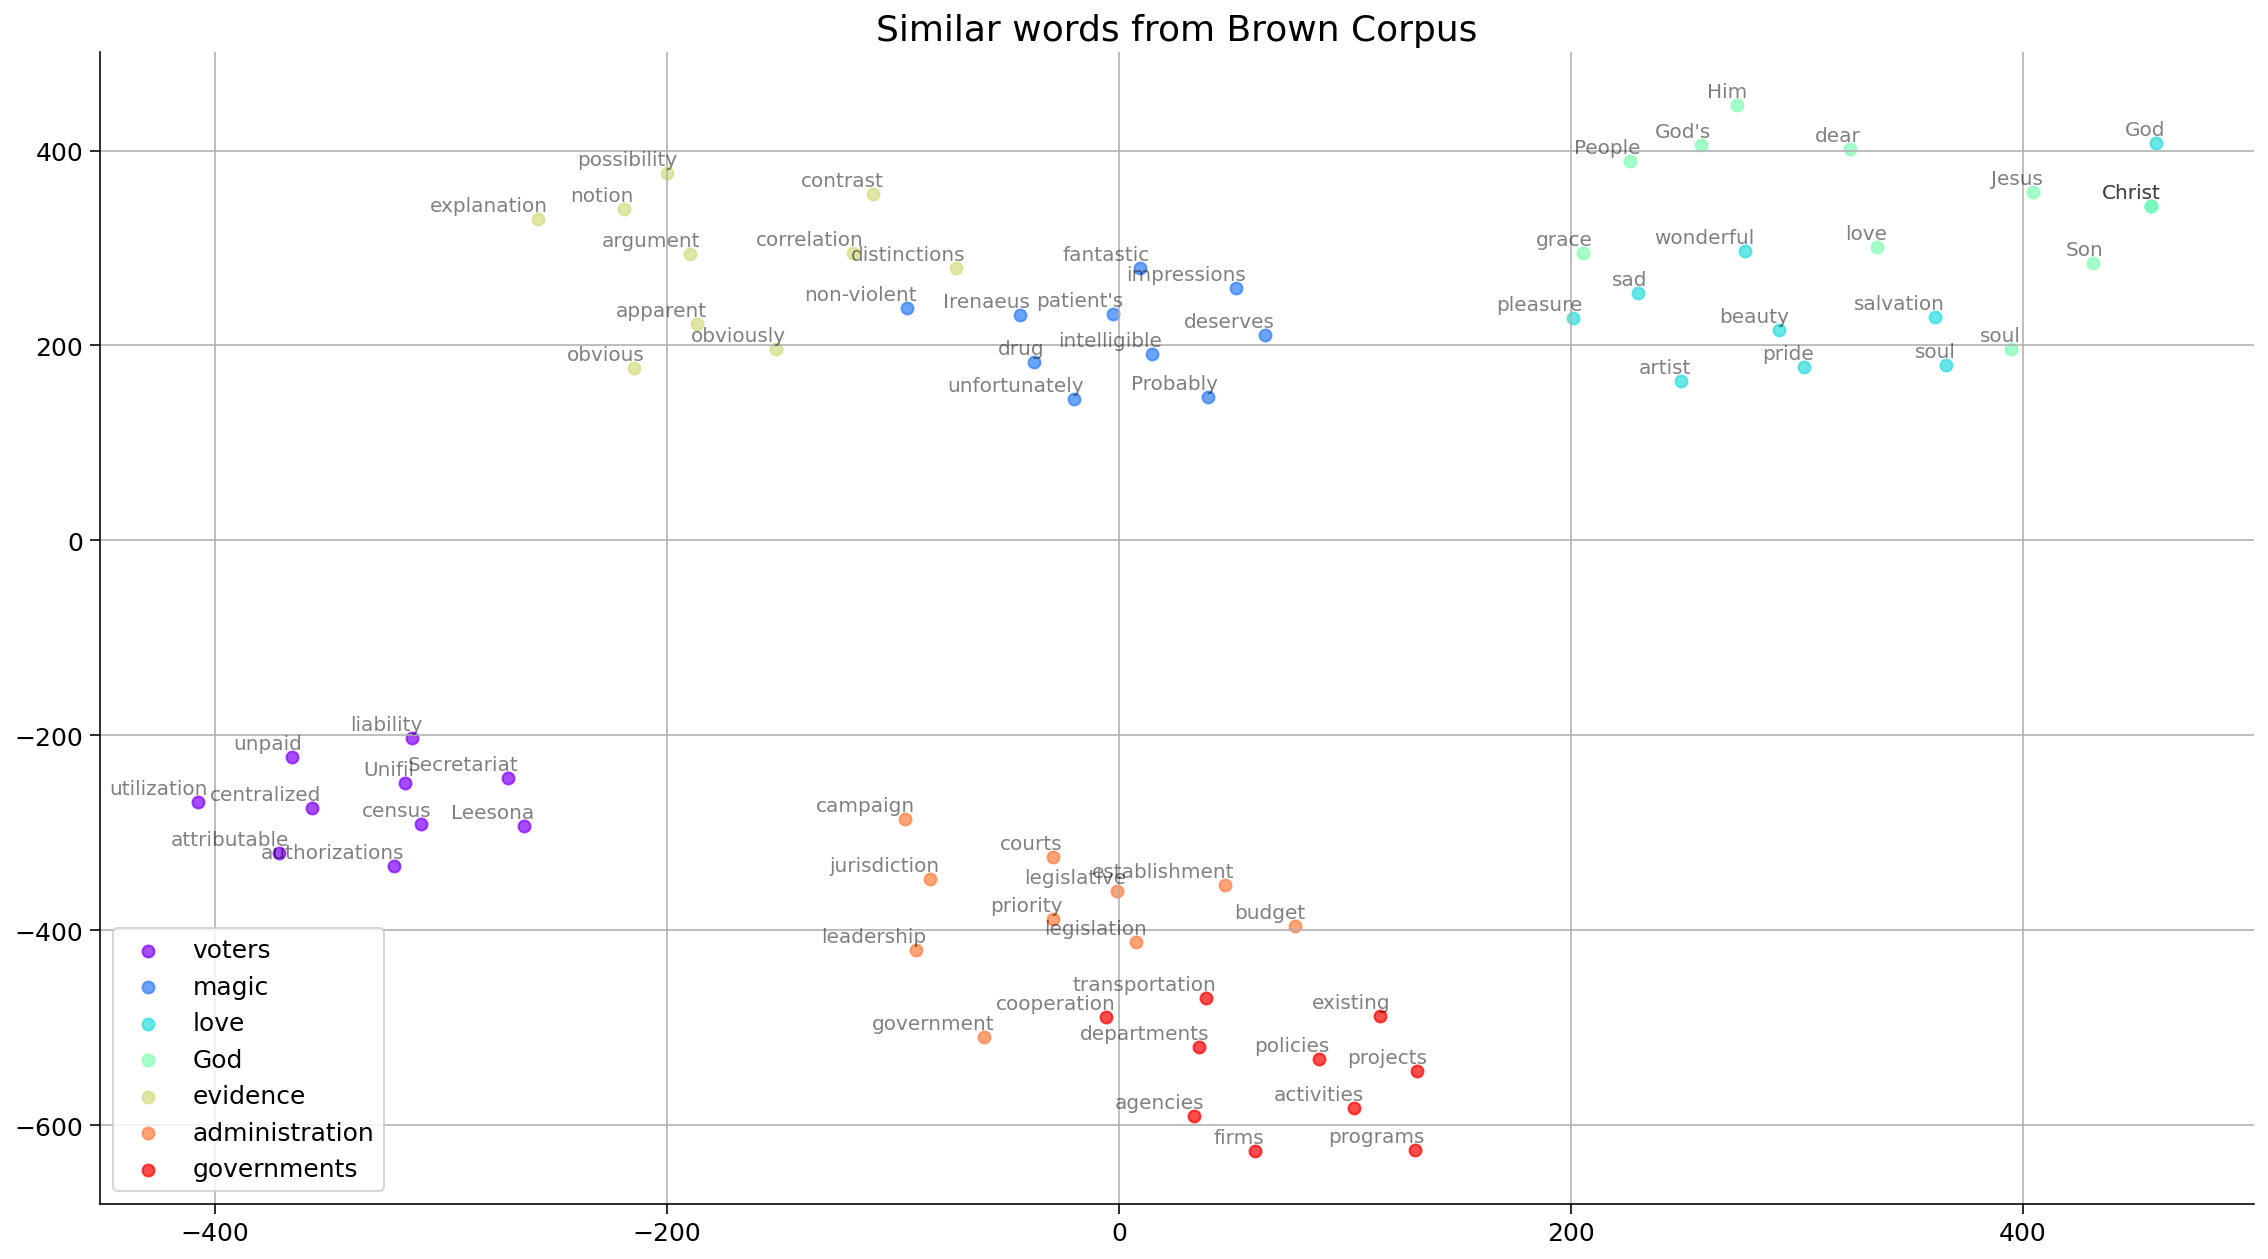

In [75]:
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
tsne_plot_similar_words('Similar words from Brown Corpus', keys, embeddings_en_2d, word_clusters, 0.7)

---
#Section 3: Neural Net with word embeddings

Let's use the pretrained FastText embeddings to train a neural network on the IMDB dataset. 

To recap, the data consists of reviews and sentiments attached to it. It is a binary classification task. As a simple preview of the upcoming neural networks, we are going to introduce neural net with word embeddings. We'll see detailed networks in the next tutorial.




### Exercise 3.1: Simple Feed Forward Net

This will load 300 dim FastText embeddings. It will take around 2-3 minutes.

Define a vanilla neural network with linear layers. Then average the word embeddings to get an embedding for the entire review.
The neural net will have one hidden layer of size 128.

In [76]:
#@title Download embeddings
embedding_fasttext = FastText('simple')

.vector_cache/wiki.simple.vec: 293MB [00:26, 11.1MB/s]                           
100%|█████████▉| 111024/111051 [00:11<00:00, 9532.02it/s]

In [77]:
#@markdown Load the Dataset
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(embedding_fasttext)

downloading aclImdb_v1.tar.gz



aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]
aclImdb_v1.tar.gz:   0%|          | 16.4k/84.1M [00:00<12:51, 109kB/s]
aclImdb_v1.tar.gz:   0%|          | 49.2k/84.1M [00:00<10:59, 128kB/s]
aclImdb_v1.tar.gz:   0%|          | 65.5k/84.1M [00:00<11:39, 120kB/s]
aclImdb_v1.tar.gz:   0%|          | 98.3k/84.1M [00:00<10:08, 138kB/s]
aclImdb_v1.tar.gz:   0%|          | 164k/84.1M [00:00<08:05, 173kB/s] 
aclImdb_v1.tar.gz:   0%|          | 279k/84.1M [00:00<06:13, 225kB/s]
aclImdb_v1.tar.gz:   1%|          | 442k/84.1M [00:01<04:44, 294kB/s]
aclImdb_v1.tar.gz:   1%|          | 803k/84.1M [00:01<03:28, 399kB/s]
aclImdb_v1.tar.gz:   1%|▏         | 1.20M/84.1M [00:01<02:35, 534kB/s]
aclImdb_v1.tar.gz:   2%|▏         | 1.61M/84.1M [00:01<01:57, 702kB/s]
aclImdb_v1.tar.gz:   3%|▎         | 2.38M/84.1M [00:01<01:26, 946kB/s]
aclImdb_v1.tar.gz:   4%|▍         | 3.51M/84.1M [00:01<01:02, 1.28MB/s]
aclImdb_v1.tar.gz:   6%|▌         | 4.77M/84.1M [00:02<00:46, 1.71MB/s]
aclImdb_v1.tar

In [78]:
class NeuralNet(nn.Module):
  def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
    super(NeuralNet, self).__init__()

    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)


  def forward(self, inputs):

    input = self.word_embeddings(inputs)  # convert text to embeddings
    ####################################################################
    # Fill in missing code below (...)
    raise NotImplementedError("Fill in the Neural Net")
    ####################################################################
    # Average the word embedddings in a sentence
    # Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = ...

    # Pass the embeddings through the neural net
    # A fully-connected layer
    x = ...
    # ReLU activation
    x = ...
    # Another fully-connected layer
    x = ...
    output = F.log_softmax(x, dim=1)

    return output


# Uncomment to check your code
# nn_model = NeuralNet(32, 2, 128, 100, 300, TEXT.vocab.vectors)
# print(nn_model)

In [79]:
#to_remove solution
class NeuralNet(nn.Module):
  def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
    super(NeuralNet, self).__init__()

    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)


  def forward(self, inputs):

    input = self.word_embeddings(inputs)  # convert text to embeddings
    # Average the word embedddings in a sentence
    # Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = F.avg_pool2d(input, (input.shape[1], 1)).squeeze(1)

    # Pass the embeddings through the neural net
    # A fully-connected layer
    x = self.fc1(pooled)
    # ReLU activation
    x = F.relu(x)
    # Another fully-connected layer
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)

    return output


# Uncomment to check your code
nn_model = NeuralNet(32, 2, 128, 100, 300, TEXT.vocab.vectors)
print(nn_model)

NeuralNet(
  (word_embeddings): Embedding(100, 300)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [80]:
# @title Training and Testing Functions

def train(model, device, train_iter, valid_iter, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in range(epochs):
    #train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1}, Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}%')

  return train_loss, train_acc, validation_loss, validation_acc


def test(model,  device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      outputs = model(text)
      _, predicted = torch.max(outputs, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

In [81]:
# Model hyperparameters
learning_rate = 0.0003
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300
epochs = 15
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)

# Model set-up
nn_model = NeuralNet(batch_size,
                     output_size,
                     hidden_size,
                     vocab_size,
                     embedding_length,
                     word_embeddings)
nn_model.to(device)
nn_start_time = time.time()
set_seed(522)
nn_train_loss, nn_train_acc, nn_validation_loss, nn_validation_acc = train(nn_model,
                                                                           device,
                                                                           train_iter,
                                                                           valid_iter,
                                                                           epochs,
                                                                           learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - nn_start_time))
test_accuracy = test(nn_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%')

Epoch: 1, Training Loss: 0.6689, Training Accuracy:  59.55%
Validation Loss: 0.6369, Validation Accuracy:  65.85%
Epoch: 2, Training Loss: 0.6279, Training Accuracy:  65.42%
Validation Loss: 0.6043, Validation Accuracy:  68.97%
Epoch: 3, Training Loss: 0.6029, Training Accuracy:  67.78%
Validation Loss: 0.5903, Validation Accuracy:  69.49%
Epoch: 4, Training Loss: 0.5934, Training Accuracy:  68.45%
Validation Loss: 0.5822, Validation Accuracy:  69.89%
Epoch: 5, Training Loss: 0.5849, Training Accuracy:  69.45%
Validation Loss: 0.5820, Validation Accuracy:  69.85%
Epoch: 6, Training Loss: 0.5816, Training Accuracy:  69.41%
Validation Loss: 0.6101, Validation Accuracy:  66.68%
Epoch: 7, Training Loss: 0.5792, Training Accuracy:  69.79%
Validation Loss: 0.5747, Validation Accuracy:  70.12%
Epoch: 8, Training Loss: 0.5754, Training Accuracy:  69.73%
Validation Loss: 0.5747, Validation Accuracy:  70.16%
Epoch: 9, Training Loss: 0.5745, Training Accuracy:  69.79%
Validation Loss: 0.5730, Val

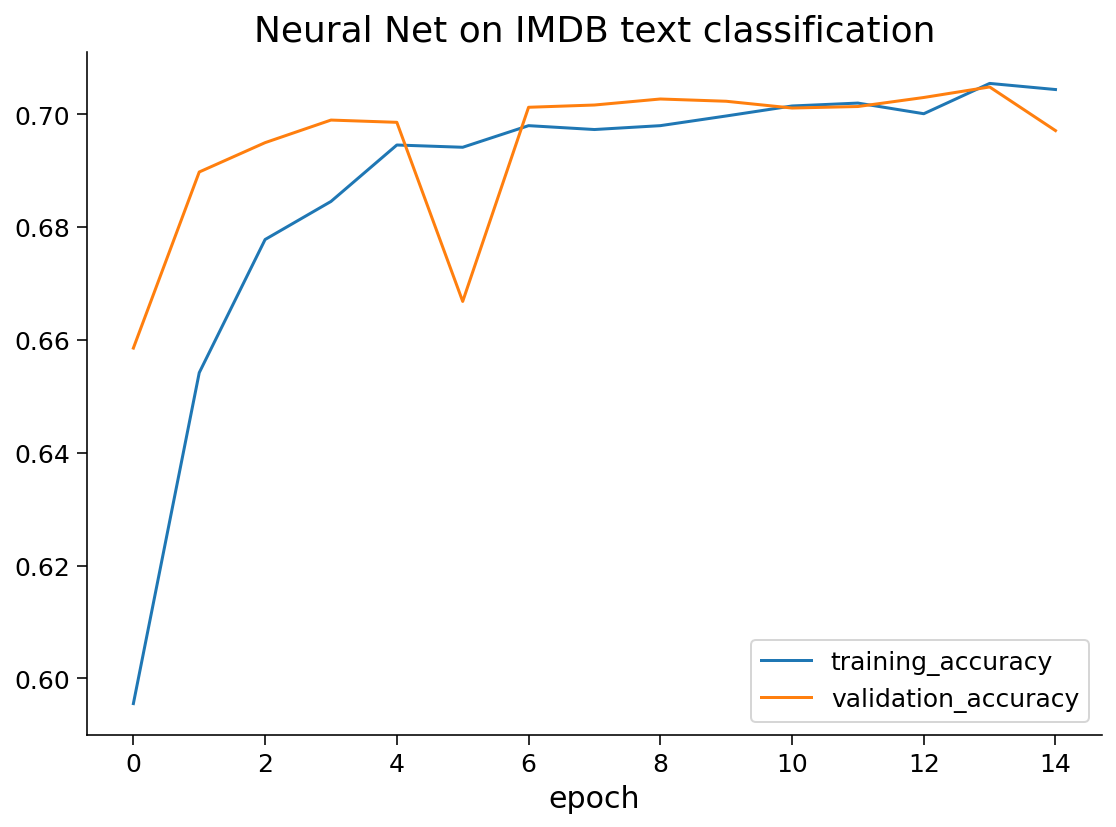

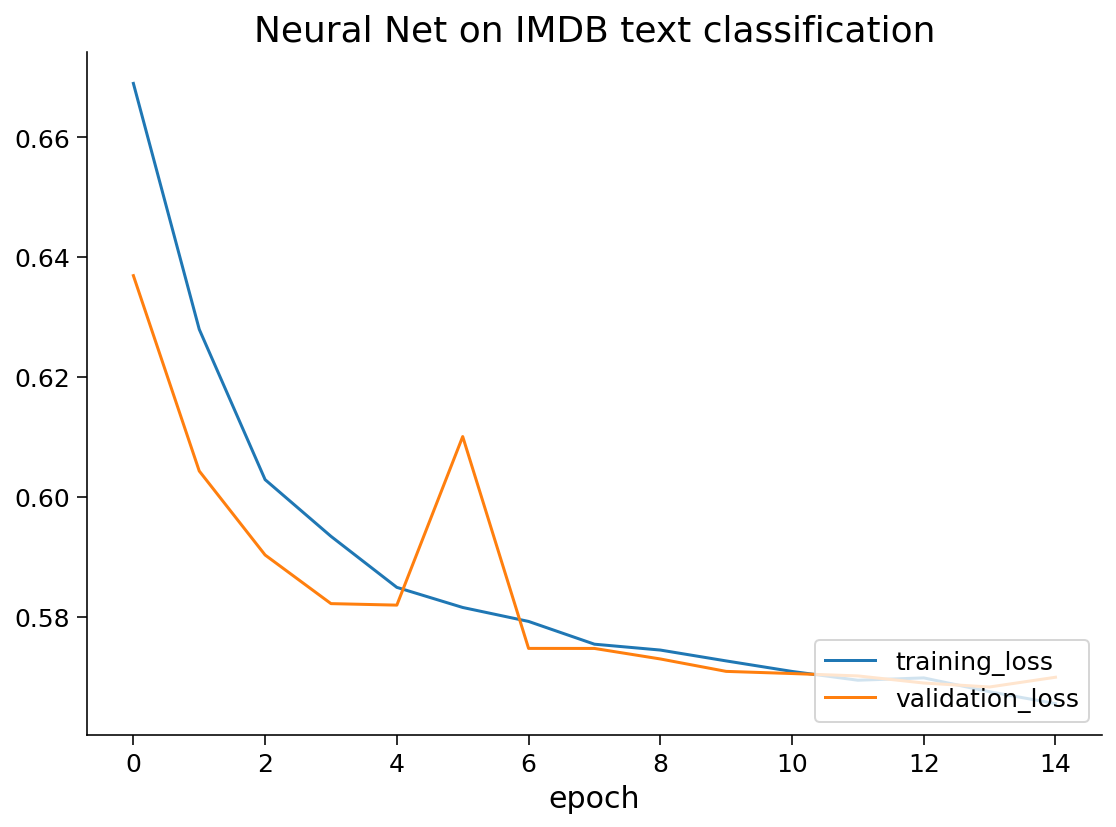

In [82]:
plot_train_val(np.arange(0, epochs),
               nn_train_acc,
               nn_validation_acc,
               'training_accuracy',
               'validation_accuracy',
               'Neural Net on IMDB text classification')

plot_train_val(np.arange(0, epochs),
               nn_train_loss,
               nn_validation_loss,
               'training_loss',
               'validation_loss',
               'Neural Net on IMDB text classification')